In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

## OUTLIERS ##

Değerler genelde 1. ve 3. çeyrek arasında dağılır ve bu bölüme robust dağılım denir. ,

INTER QUARTILE RANGE


IQR değeri= Q3-Q1


Lower bound = Q1 - 1.5*IQR 


Upper bound = Q3 - 1.5*IQR

In [3]:
df = pd.read_csv("titanic.csv")

In [4]:
datayedek = pd.read_csv("titanic.csv")

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


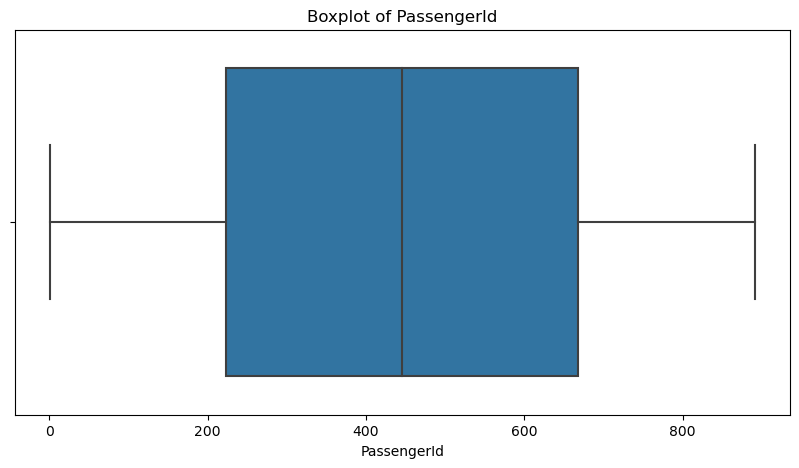

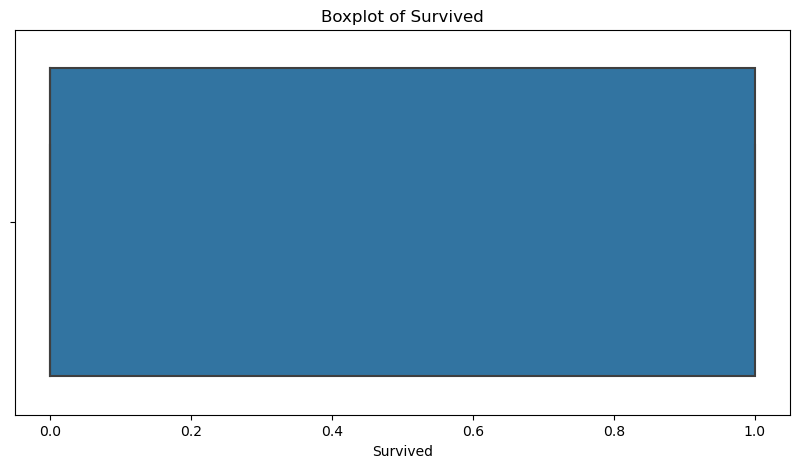

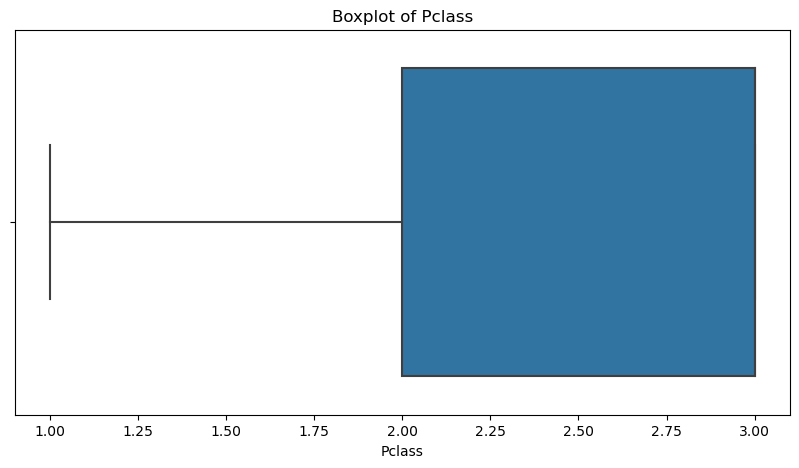

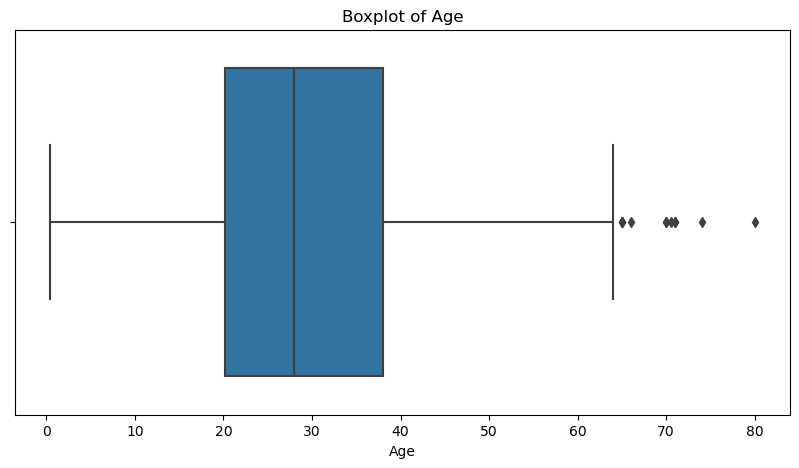

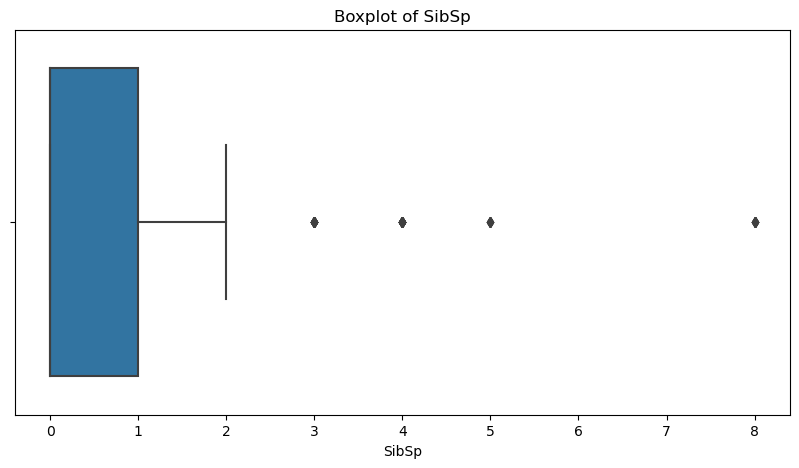

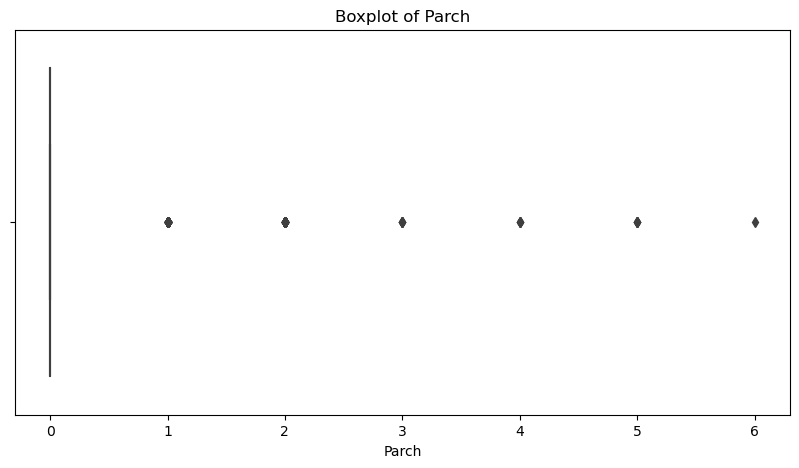

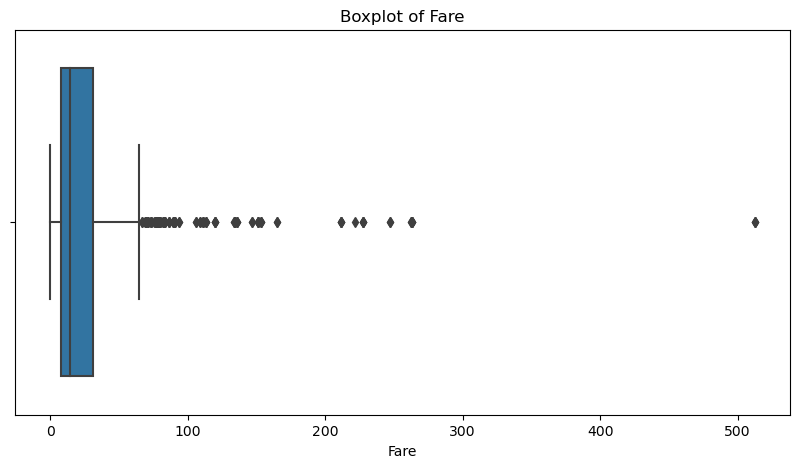

In [7]:
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


We can best view numerical outliers with box plots and histogram charts.

## How to catch outliers. ##

In [8]:
q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)

In [9]:
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

In [10]:
#OUTLIERS 
df[(df["Age"] < low) | (df["Age"] > up)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S


In [11]:
# INDEX OF OUTLIERS
df[(df["Age"] < low) | (df["Age"] > up)].index

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [12]:
df[(df["Age"] < low) | (df["Age"] > up)].any(axis=None)

True

### FUNCTIONS ### 

In [13]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


In [14]:
low, up = outlier_thresholds(df, "Fare")
low

-26.724

In [15]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [16]:
check_outlier(df, "Age")


True

In [17]:
def grab_col_names(dataframe, cat_th=10, car_th=20):


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [20]:
cat_cols, num_cols, cat_but_car,num_but_cat = grab_col_names(df)


Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [21]:
print("Categorical Columns:", cat_cols, "Numerical Columns:", num_cols, "Seems like a Categoric but numeric:", cat_but_car, sep= "\n")

Categorical Columns:
['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch']
Numerical Columns:
['PassengerId', 'Age', 'Fare']
Seems like a Categoric but numeric:
['Name', 'Ticket', 'Cabin']


In [22]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


In [23]:
grab_outliers(df, "Age", index=True)


     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
280          281         0       3                Duane, Mr. Frank  male   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   66.0      0      0  C.A. 24579  10.5000   NaN        S  
54   65.0      0      1      113509  61.9792   B30        C  
96   71.0      0      0    PC 17754  34.6542    A5        C  
116  70.5      0      0      370369   7.7500   NaN        Q  
280  65.0      0      0      336439   7.7500   NaN        Q  


Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

### Aykırı değer problemini çözmek! : 

#### Removing Outliers from data:

In [33]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

#### Suppression of outliers: 

In [34]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

### Example Usage of Functions:

In [25]:
#Numerik kolonların tespiti ve kullanımı: 
cat_cols, num_cols, cat_but_car,num_but_cat = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [26]:
print("Categorical Columns:", cat_cols, "Numerical Columns:", num_cols, "Seems like a Categoric but numeric:", cat_but_car, sep= "\n")

Categorical Columns:
['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch']
Numerical Columns:
['PassengerId', 'Age', 'Fare']
Seems like a Categoric but numeric:
['Name', 'Ticket', 'Cabin']


In [29]:
num_cols = [col for col in num_cols if col not in "PassengerId"]

In [30]:
for col in num_cols:
    print(col, check_outlier(df, col))

Age True
Fare True


In [31]:
grab_outliers(df, "Age", index=True)

     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
280          281         0       3                Duane, Mr. Frank  male   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   66.0      0      0  C.A. 24579  10.5000   NaN        S  
54   65.0      0      1      113509  61.9792   B30        C  
96   71.0      0      0    PC 17754  34.6542    A5        C  
116  70.5      0      0      370369   7.7500   NaN        Q  
280  65.0      0      0      336439   7.7500   NaN        Q  


Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [35]:
for col in num_cols:
    new_df = remove_outlier(df, col)

In [38]:
df # 891

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [39]:
new_df # 775

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#### Suppression of outliers: 

In [41]:
for col in num_cols:
    print(col, check_outlier(df, col))


Age True
Fare True


In [42]:
for col in num_cols:
    replace_with_thresholds(df, col)


In [43]:

for col in num_cols:
    print(col, check_outlier(df, col))

Age False
Fare False


In [44]:
df # 891

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,65.6344,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Local Outlier Analysis

In [45]:
df = sns.load_dataset('diamonds')
df = df.select_dtypes(include=['float64', 'int64'])
df = df.dropna()
df.head()


,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [46]:
df.shape

(53940, 7)

In [47]:
for col in df.columns:
    print(col, check_outlier(df, col))

carat True
depth True
table True
price True
x True
y True
z True


In [48]:
low, up = outlier_thresholds(df, "carat")


In [49]:
df[((df["carat"] < low) | (df["carat"] > up))].shape


(1889, 7)

In [50]:
low, up = outlier_thresholds(df, "depth")


In [51]:
df[((df["depth"] < low) | (df["depth"] > up))].shape


(2545, 7)

In [52]:
#20 is a predefined value
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)

array([-1, -1, -1, ...,  1,  1,  1])

In [53]:
df_scores = clf.negative_outlier_factor_
df_scores[0:5]
# df_scores = -df_scores
np.sort(df_scores)[0:5]

array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092])

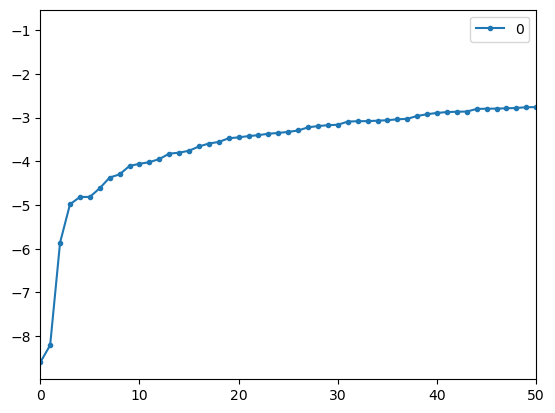

In [54]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()

In [55]:
th = np.sort(df_scores)[3]
th

-4.984151747711709

In [56]:
df[df_scores < th]


,carat,depth,table,price,x,y,z
41918,1.03,78.2,54.0,1262,5.72,5.59,4.42
48410,0.51,61.8,54.7,1970,5.12,5.15,31.80
49189,0.51,61.8,55.0,2075,5.15,31.80,5.12


In [57]:
df[df_scores < th].shape


(3, 7)

In [58]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T


,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
carat,53940.0,0.797940,0.474011,0.2,0.24,0.30,0.70,1.04,1.51,2.18,5.01
depth,53940.0,61.749405,1.432621,43.0,57.90,59.30,61.80,62.50,63.30,65.60,79.00
table,53940.0,57.457184,2.234491,43.0,53.00,54.00,57.00,59.00,60.00,64.00,95.00
price,53940.0,3932.799722,3989.439738,326.0,429.00,544.00,2401.00,5324.25,9821.00,17378.22,18823.00
x,53940.0,5.731157,1.121761,0.0,4.02,4.29,5.70,6.54,7.31,8.36,10.74
y,53940.0,5.734526,1.142135,0.0,4.04,4.30,5.71,6.54,7.30,8.34,58.90
z,53940.0,3.538734,0.705699,0.0,2.48,2.65,3.53,4.04,4.52,5.15,31.80


In [59]:
df[df_scores < th].index


Index([41918, 48410, 49189], dtype='int64')

In [60]:
df_filtered = df.drop(labels=df[df_scores < th].index, axis=0)
df_filtered

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74
